# COMP0036: Beat the Bookie

### Table of Contents

1. [Introduction](#1-Introduction)

2. [Data Import](#2-Data-Import)

3. [Data Transformation & Exploration](#3-Data-Transformation-&-Exploration)

4. [Methodology Overview](#4-Methodology-Overview)

5. [Model Training & Validation](#5-Model-Training-&-Validation) 

6. [Results](#6-Results)

7. [Final Predictions on Test Set](#7-Final-Predictions-on-Test-Set)

### 1. Introduction

### 2. Data Import

In [93]:
import pandas as pd

# Configure Pandas display settings for better readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Load dataset
df = pd.read_csv('../data/epl-training.csv')

# Show the first few rows
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


### 3. Data Transformation & Exploration

#### 3.1. Data Cleaning

In [94]:
# Define constants
N_SEASONS = 24
MATCHES_PER_SEASON = 380
EXPECTED_LENGTH = N_SEASONS * MATCHES_PER_SEASON

# Check the initial length against the expected length
print(f"Length of DataFrame before cleaning: {len(df)}")
print(f"This is {len(df) - EXPECTED_LENGTH} more than the expected length of {EXPECTED_LENGTH}.")

# Remove rows that are completely empty
df.dropna(how="all", inplace=True)

# Check for duplicates in the first three columns
duplicates = df.iloc[:, :3].duplicated()

if duplicates.any():
    # Get indices of duplicate rows
    duplicate_indices = duplicates[duplicates].index.tolist()
    print(f"Duplicate rows found at indices: {duplicate_indices}")
    print(f"Total duplicates: {len(duplicate_indices)}")

    # Remove those duplicates
    df.drop(index=duplicate_indices, inplace=True)
    print(f"Duplicate rows removed. New length: {len(df)}")
else:
    print("No duplicates found in the first three columns.")

# Print final info
print(f"Final length of the cleaned DataFrame: {len(df)}")


Length of DataFrame before cleaning: 9221
This is 101 more than the expected length of 9120.
Duplicate rows found at indices: [8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940]
Total duplicates: 100
Duplicate rows removed. New length: 9120
Final length of the cleaned DataFrame: 9120


#### 3.2. Web Scraping
```py
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_market_val(year_start, year_end):
    """
    Scrapes Transfermarkt market value data for the Premier League from season year_start 
    up to (but not including) year_end. Saves the final combined data to a CSV file.
    """

    # Fake user agent to avoid 403 Forbidden errors
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/91.0.4472.124 Safari/537.36"
        )
    }

    combined_df = pd.DataFrame()

    # Loop through each season in the specified range
    for year in range(year_start, year_end):
        data_list = []
        print(f"Processing season: {year}")

        # Build the Transfermarkt URL for the given season
        url = f"https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id={year}#google_vignette"
        
        # Send GET request
        response = requests.get(url, headers=headers)
        print(f"Status code: {response.status_code}")

        # Parse the HTML using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locate the table with class 'items'
        table = soup.find('table', class_='items')
        rows = table.find('tbody').find_all('tr')

        # Extract the desired data from each row
        for row in rows:
            columns = row.find_all('td')
            row_data = {
                'Year': year,
                'Club': columns[1].text.strip(),
                'TMV': columns[6].text.strip()[1:],  # Remove the currency symbol (e.g., '£')
            }
            data_list.append(row_data)

        # Create a DataFrame for the current season
        df = pd.DataFrame(data_list)

        # Remove rows that are entirely empty
        df = df[~df.apply(lambda row: row.astype(str).str.strip().eq('').all(), axis=1)]

        # Concatenate with the main DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

        # Sleep to avoid hitting the server too frequently
        time.sleep(5)

    # Save the final DataFrame to a CSV file
    combined_df.to_csv('Engineered Data/Final Data/marketval.csv', index=False)
    print("Data saved to 'Engineered Data/Final Data/marketval.csv'.")

# Example usage
get_market_val(2000, 2025)

```

#### 3.3. Exploring Scraped Data

##### 3.3.1. 14-Day Match Density and Match Attendance

In [95]:
import pandas as pd
from datetime import timedelta

# Load data scraping CSV files
EPL_S = pd.read_csv('../scraped-data/combined-epl.csv')
FA_S = pd.read_csv('../scraped-data/combined-fa-e.csv')
EFL_S = pd.read_csv('../scraped-data/combined-efl-e.csv')
UCL_S = pd.read_csv('../scraped-data/combined-ucl-e.csv')
UEL_S = pd.read_csv('../scraped-data/combined-uel-e.csv')

# Tag each DataFrame to identify its source
EPL_S.insert(0, 'df name', 'EPL')
FA_S.insert(0, 'df name', 'FA')
EFL_S.insert(0, 'df name', 'EFL')
UCL_S.insert(0, 'df name', 'UCL')
UEL_S.insert(0, 'df name', 'UEL')

# Combine all DataFrames into one
combined = pd.concat([EPL_S, FA_S, EFL_S, UCL_S, UEL_S], ignore_index=True)

# Convert the 'Date' columns to datetime using DD/MM/YYYY format
# (Fixes warning about parsing with dayfirst=False)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
combined['Date'] = pd.to_datetime(combined['Date'], format='%d/%m/%Y')

# Sort the combined DataFrame by date and home team
combined.sort_values(['Date', 'HomeTeam'], ascending=[True, True], inplace=True)

# Define a function to count matches for a given team in the prior 14 days
def calculate_matches(team, match_date):
    start_date = match_date - timedelta(days=14)
    matches = combined.loc[
        (
            (combined['HomeTeam'] == team) |
            (combined['AwayTeam'] == team)
        ) &
        (combined['Date'] >= start_date) &
        (combined['Date'] < match_date)
    ]
    return len(matches)

# Filter EPL rows and make a copy to avoid SettingWithCopyWarning
combined_epl = combined.loc[combined['df name'] == 'EPL'].copy()

# Calculate 14-day match density for home and away teams
combined_epl['H14'] = combined_epl.apply(
    lambda row: calculate_matches(row['HomeTeam'], row['Date']), axis=1
)
combined_epl['A14'] = combined_epl.apply(
    lambda row: calculate_matches(row['AwayTeam'], row['Date']), axis=1
)

# Merge H14, A14, and Attendance columns into the main epl DataFrame
df = df.merge(
    combined_epl[['Date', 'HomeTeam', 'AwayTeam', 'H14', 'A14', 'Attendance']],
    on=['Date', 'HomeTeam', 'AwayTeam'],
    how='left'
)

# Convert the Date column back to DD/MM/YYYY format for consistency
df['Date'] = df['Date'].dt.strftime('%d/%m/%Y')

# Preview the first few rows
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043"
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914"
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624"
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223"
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010"


##### 3.3.2. Referee Strictness

In [96]:
# Function to standardize referee names based on index ranges
def StandardNames(index, name):
    """
    Standardizes referee names differently depending on the row index.
    """
    # First 380 rows: split and keep first initial + last name
    if index <= 379:
        parts = name.split()
        if len(parts) > 1:
            return f"{parts[0][0]} {parts[1]}"
        else:
            return name

    # Rows 380 to 549: remove periods, then keep first initial + last name
    elif index <= 549:
        parts = name.replace('.', '').split()
        if len(parts) > 1:
            return f"{parts[0][0]} {parts[-1]}"
        else:
            return name

    # Rows 550 to 759: remove commas/periods, swap order, keep first initial + last name
    elif index <= 759:
        parts = name.replace(',', '').replace('.', '').split()
        if len(parts) > 1:
            return f"{parts[1][0]} {parts[0]}"
        else:
            return name

    # Rows 1855 to 1863: keep last letter of first name + last name
    elif index >= 1855 and index <= 1863:
        parts = name.split()
        if len(parts) > 1:
            return f"{parts[0][-1]} {parts[1]}"
        else:
            return name

    # Default: do not modify name
    else:
        return name

# Apply the StandardNames function to each row
df['Referee'] = df.apply(lambda row: StandardNames(row.name, row['Referee']), axis=1)

# Define a lookup dictionary for inconsistent names
name_corrections = {
    "D Gallaghe": "D Gallagher",
    "D Gallagh": "D Gallagher"
}

# Apply corrections to the 'Referee' column
df['Referee'] = df['Referee'].apply(
    lambda name: name_corrections[name] if name in name_corrections else name
)

# Get unique refs and initialize dictionaries
refs = df['Referee'].unique()
Y = {ref: 0 for ref in refs}
R = {ref: 0 for ref in refs}
MatchCount = {ref: 0 for ref in refs}
strictness = {}

# Loop over DataFrame rows to count yellow/red cards and appearances
for index, row in df.iterrows():
    ref = row['Referee']
    if pd.notna(ref):
        Y[ref] += row['AY'] + row['HY']  # Summation of all yellow cards
        R[ref] += row['AY'] + row['HY']  # In the original code: same as above (possibly an intentional choice)
        MatchCount[ref] += 1

# Compute "strictness" based on total cards and matches
for ref in refs:
    if MatchCount[ref] > 0:
        strictness[ref] = (Y[ref] + 3 * R[ref]) / MatchCount[ref]
    else:
        strictness[ref] = 0

# Add a 'Strictness' column to the epl DataFrame
df['Strictness'] = df['Referee'].map(strictness)

# Preview the updated DataFrame
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236


##### 3.3.3. Standings

In [97]:
from tqdm import tqdm

# Enable tqdm for Pandas apply operations
tqdm.pandas()

# Convert FTR to winner name or 'Draw'
df['FTR'] = df.apply(
    lambda row: row['HomeTeam'] if row['FTR'] == 'H' 
                else ('Draw' if row['FTR'] == 'D' else row['AwayTeam']), 
    axis=1
)

# Assign 'Season' based on row index (380 matches per season)
df['Season'] = df.index // 380
df['Season'] = df['Season'].apply(lambda i: 2000 + i)  # e.g., 0 -> 2000, 1 -> 2001, etc.

# Assign 'Round' values (there are 38 rounds in a 380-match season)
roundindex = (df.index - 10) // 10 + 1
df['Round'] = (roundindex % 38) + 1

# Recursive function to calculate cumulative points
def get_pts(team, season, current_round):
    """
    Returns the points accumulated by 'team' up to (and including) 'current_round'
    in 'season' (where season=2018 means 2018-2019, etc.).
    """
    if current_round == 1:
        return 0
    
    # Filter for the previous round in the same season
    prev_round_data = df[
        (df['Season'] == season) & 
        (df['Round'] == current_round - 1)
    ]
    
    # Conditions to check if the team won or drew in the previous round
    homewin = (prev_round_data['HomeTeam'] == team) & (prev_round_data['FTR'] == team)
    awaywin = (prev_round_data['AwayTeam'] == team) & (prev_round_data['FTR'] == team)
    draw = (
        ((prev_round_data['HomeTeam'] == team) | (prev_round_data['AwayTeam'] == team)) 
        & (prev_round_data['FTR'] == 'Draw')
    )

    # Points in the previous round
    if homewin.any() or awaywin.any():
        roundpts = 3
    elif draw.any():
        roundpts = 1
    else:
        roundpts = 0
    
    # Recursively add the points from earlier rounds
    return roundpts + get_pts(team, season, current_round - 1)

# Calculate home and away teams' cumulative points
df['Hpts'] = df.progress_apply(
    lambda row: get_pts(row['HomeTeam'], row['Season'], row['Round']), 
    axis=1
)
df['Apts'] = df.progress_apply(
    lambda row: get_pts(row['AwayTeam'], row['Season'], row['Round']), 
    axis=1
)

# Revert FTR back to 'H', 'D', or 'A'
df['FTR'] = df.progress_apply(
    lambda row: 'H' if row['FTR'] == row['HomeTeam']
                else ('D' if row['FTR'] == 'Draw' else 'A'),
    axis=1
)

# Show the first few rows
df.head()


100%|██████████| 9120/9120 [00:00<00:00, 206934.52it/s]


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0


##### 3.3.4. Other Features

In [98]:
from collections import defaultdict, deque

# Temporarily add the HomePoints/AwayPoints features for easier tracking of match outcomes
df['HomePoints'] = df['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
df['AwayPoints'] = df['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))

# Define rolling window size for form metrics (e.g., last 10 matches)
form_window = 10

# Dictionaries to track stats for each team
team_strength_stats = {}      # Contains overall points & games played
team_goals_scored = {}        # Cumulative goals scored by each team
team_goals_conceded = {}      # Cumulative goals conceded by each team
team_form_points = {}         # Rolling points over last `form_window` matches
team_form_goal_diff = {}      # Rolling goal difference over last `form_window` matches
team_win_streak = {}          # Current win streak
h2h_record = defaultdict(lambda: {"matches": 0, "home_wins": 0, "away_wins": 0})  # H2H stats

# --- Helper Functions ---

# Overall team strength
def get_team_strength(team):
    if team in team_strength_stats and team_strength_stats[team]['games'] > 0:
        return team_strength_stats[team]['points'] / team_strength_stats[team]['games']
    return 0

def update_team_strength(team, points):
    if team not in team_strength_stats:
        team_strength_stats[team] = {'points': 0, 'games': 0}
    team_strength_stats[team]['points'] += points
    team_strength_stats[team]['games'] += 1

# Goal scoring rate
def get_goal_scoring_rate(team):
    if team in team_goals_scored and team_strength_stats[team]['games'] > 0:
        return team_goals_scored[team] / team_strength_stats[team]['games']
    return 0

def update_goal_scoring_rate(team, goals):
    if team not in team_goals_scored:
        team_goals_scored[team] = 0
    team_goals_scored[team] += goals

# Defensive strength
def get_defensive_strength(team):
    if team in team_goals_conceded and team_strength_stats[team]['games'] > 0:
        return team_goals_conceded[team] / team_strength_stats[team]['games']
    return 0

def update_defensive_strength(team, goals_conceded):
    if team not in team_goals_conceded:
        team_goals_conceded[team] = 0
    team_goals_conceded[team] += goals_conceded

# Team form (last `form_window` matches)
def get_form_points(team):
    if team in team_form_points and len(team_form_points[team]) > 0:
        return sum(team_form_points[team]) / len(team_form_points[team])
    return 0

def update_form_points(team, points):
    if team not in team_form_points:
        team_form_points[team] = deque(maxlen=form_window)
    team_form_points[team].append(points)

def get_goal_diff_form(team):
    if team in team_form_goal_diff and len(team_form_goal_diff[team]) > 0:
        return sum(team_form_goal_diff[team])
    return 0

def update_goal_diff_form(team, goal_diff):
    if team not in team_form_goal_diff:
        team_form_goal_diff[team] = deque(maxlen=form_window)
    team_form_goal_diff[team].append(goal_diff)

def get_win_streak(team):
    return team_win_streak.get(team, 0)

def update_win_streak(team, result):
    if team not in team_win_streak:
        team_win_streak[team] = 0
    if result == 3:  # Win
        team_win_streak[team] += 1
    else:            # Loss or Draw
        team_win_streak[team] = 0

# H2H functions
def calculate_h2h_win_rate(team, opponent, is_home):
    record = h2h_record[(team, opponent)]
    wins = record['home_wins'] if is_home else record['away_wins']
    total_matches = record['matches']
    return wins / total_matches if total_matches > 0 else 0

def update_h2h_record(home_team, away_team, result):
    h2h_record[(home_team, away_team)]['matches'] += 1
    h2h_record[(away_team, home_team)]['matches'] += 1
    if result == 'H':
        h2h_record[(home_team, away_team)]['home_wins'] += 1
    elif result == 'A':
        h2h_record[(away_team, home_team)]['away_wins'] += 1

# --- Lists to store computed metrics for each row ---
hts_list = []
ats_list = []
home_gsr_list = []
away_gsr_list = []
home_ds_list = []
away_ds_list = []
home_form_points_list = []
away_form_points_list = []
home_goal_diff_form_list = []
away_goal_diff_form_list = []
home_win_streak_list = []
away_win_streak_list = []
home_h2h_win_rate_list = []
away_h2h_win_rate_list = []

# --- Main loop to process each match ---
for _, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    result = row['FTR']
    
    # Calculate current metrics before updating
    hts = get_team_strength(home_team)
    ats = get_team_strength(away_team)
    home_gsr = get_goal_scoring_rate(home_team)
    away_gsr = get_goal_scoring_rate(away_team)
    home_ds = get_defensive_strength(home_team)
    away_ds = get_defensive_strength(away_team)
    home_form_points = get_form_points(home_team)
    away_form_points = get_form_points(away_team)
    home_goal_diff_form = get_goal_diff_form(home_team)
    away_goal_diff_form = get_goal_diff_form(away_team)
    home_win_streak = get_win_streak(home_team)
    away_win_streak = get_win_streak(away_team)
    home_h2h_win_rate = calculate_h2h_win_rate(home_team, away_team, is_home=True)
    away_h2h_win_rate = calculate_h2h_win_rate(away_team, home_team, is_home=False)
    
    # Append values to lists
    hts_list.append(hts)
    ats_list.append(ats)
    home_gsr_list.append(home_gsr)
    away_gsr_list.append(away_gsr)
    home_ds_list.append(home_ds)
    away_ds_list.append(away_ds)
    home_form_points_list.append(home_form_points)
    away_form_points_list.append(away_form_points)
    home_goal_diff_form_list.append(home_goal_diff_form)
    away_goal_diff_form_list.append(away_goal_diff_form)
    home_win_streak_list.append(home_win_streak)
    away_win_streak_list.append(away_win_streak)
    home_h2h_win_rate_list.append(home_h2h_win_rate)
    away_h2h_win_rate_list.append(away_h2h_win_rate)
    
    # Update stats after reading the row
    update_team_strength(home_team, row['HomePoints'])
    update_team_strength(away_team, row['AwayPoints'])
    update_goal_scoring_rate(home_team, row['FTHG'])
    update_goal_scoring_rate(away_team, row['FTAG'])
    update_defensive_strength(home_team, row['FTAG'])
    update_defensive_strength(away_team, row['FTHG'])
    
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']
    update_form_points(home_team, row['HomePoints'])
    update_form_points(away_team, row['AwayPoints'])
    update_goal_diff_form(home_team, home_goal_diff)
    update_goal_diff_form(away_team, away_goal_diff)
    update_win_streak(home_team, row['HomePoints'])
    update_win_streak(away_team, row['AwayPoints'])
    
    # Update head-to-head stats
    update_h2h_record(home_team, away_team, result)

# Assign computed metrics back to the DataFrame
df['HTS'] = hts_list
df['ATS'] = ats_list
df['HGSR'] = home_gsr_list
df['AGSR'] = away_gsr_list
df['Home_DS'] = home_ds_list
df['Away_DS'] = away_ds_list
df['Home_Form_Points'] = home_form_points_list
df['Away_Form_Points'] = away_form_points_list
df['Home_Goal_Diff_Form'] = home_goal_diff_form_list
df['Away_Goal_Diff_Form'] = away_goal_diff_form_list
df['Home_Win_Streak'] = home_win_streak_list
df['Away_Win_Streak'] = away_win_streak_list
df['Home_H2H_Win_Rate'] = home_h2h_win_rate_list
df['Away_H2H_Win_Rate'] = away_h2h_win_rate_list

# Remove the temporary columns
df.drop(columns=['HomePoints', 'AwayPoints'], inplace=True)

# Preview the updated DataFrame
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


##### 3.3.5. Team Market Value, Match Possession, Set Piece

In [99]:
import pandas as pd

# Load additional scraped data
MarketVal = pd.read_csv('../scraped-data/market-values.csv')
Posession = pd.read_csv('../scraped-data/possession-data.csv')
SetPiece = pd.read_csv('../scraped-data/set-piece.csv')

# Dictionary for team name corrections
Alterations = {
    'Manchester City': 'Man City',
    'Arsenal FC': 'Arsenal',
    'Chelsea FC': 'Chelsea',
    'Liverpool FC': 'Liverpool',
    'Manchester United': 'Man United',
    'Tottenham Hotspur': 'Tottenham',
    'Newcastle United': 'Newcastle',
    'Brighton & Hove Albion': 'Brighton',
    'West Ham United': 'West Ham',
    'Nottingham Forest': "Nott'm Forest",
    'Brentford FC': 'Brentford',
    'Wolverhampton Wanderers': 'Wolves',
    'AFC Bournemouth': 'Bournemouth',
    'Everton FC': 'Everton',
    'Fulham FC': 'Fulham',
    'Southampton FC': 'Southampton',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'West Bromwich Albion': 'West Brom',
    'Queens Park Rangers': 'QPR',
    'Hull City': 'Hull',
    'Stoke City': 'Stoke',
    'Swansea City': 'Swansea',
    'Manchester Utd': 'Man United',
    'Newcastle Utd': 'Newcastle',
    "Nott'ham Forest": "Nott'm Forest",
    "Luton Town": "Luton",
    'Sheffield Utd': 'Sheffield United',
    'Leeds United': 'Leeds',
    'Norwich City': 'Norwich',
    'Cardiff City': 'Cardiff',
    'Birmingham City': 'Birmingham',
    'Blackburn Rovers': 'Blackburn',
    'Blackpool FC': 'Blackpool',
    'Bolton Wanderers': 'Bolton',
    'Bradford City': 'Bradford',
    'Burnley FC': 'Burnley',
    'Charlton Athletic': 'Charlton',
    'Coventry City': 'Coventry',
    'Derby County': 'Derby',
    'Huddersfield Town': 'Huddersfield',
    'Middlesbrough FC': 'Middlesbrough',
    'Portsmouth FC': 'Portsmouth',
    'Reading FC': 'Reading',
    'Sunderland AFC': 'Sunderland',
    'Watford FC': 'Watford',
    'Wigan Athletic': 'Wigan',
}

# Apply team name corrections in each DataFrame
MarketVal['Club'] = MarketVal['Club'].apply(lambda name: Alterations[name] if name in Alterations else name)
Posession['Team'] = Posession['Team'].apply(lambda name: Alterations[name] if name in Alterations else name)
SetPiece['Team'] = SetPiece['Team'].apply(lambda name: Alterations[name] if name in Alterations else name)

# Check how many teams exist in each dataset
cleaneplteams = list(df['HomeTeam'].unique())
MarketValteams = list(MarketVal['Club'].unique())
Posessionteams = list(Posession['Team'].unique())
setPieceteams = list(SetPiece['Team'].unique())

print(f"Number of teams in the clean EPL data: {len(cleaneplteams)}")
print(f"Number of teams in the MarketVal data:   {len(MarketValteams)}")
print(f"Number of teams in the Possession data:  {len(Posessionteams)}")
print(f"Number of teams in the SetPiece data:    {len(setPieceteams)}")

# Identify names not found in the dictionary
uniqueepl = sorted([team for team in cleaneplteams if team not in MarketValteams])
UniqueMarketVal = sorted([team for team in MarketValteams if team not in cleaneplteams])
UniquePosession = [team for team in Posessionteams if team not in cleaneplteams]
UniqueSetPiece = [team for team in setPieceteams if team not in cleaneplteams]

# Apply final corrections (just in case) after the check
MarketVal['Club'] = MarketVal['Club'].apply(lambda name: Alterations[name] if name in Alterations else name)
Posession['Team'] = Posession['Team'].apply(lambda name: Alterations[name] if name in Alterations else name)
SetPiece['Team'] = SetPiece['Team'].apply(lambda name: Alterations[name] if name in Alterations else name)

# Clean MarketVal's TMV column by converting from string to numeric
MarketVal['TMV'] = MarketVal['TMV'].apply(
    lambda val: float(str(val)[:-2]) * 1000 if isinstance(val, str) and val.endswith('bn')
    else (float(str(val)[:-1]) if isinstance(val, str) and val.endswith('m') else val)
)

# Merge MarketVal into `epl` for HomeTeam
df = pd.merge(
    df,
    MarketVal.rename(columns={'Club': 'HomeTeam', 'TMV': 'HTV($m)', 'Year': 'Season'}),
    how='left',
    on=['HomeTeam', 'Season']
)

# Merge MarketVal into `epl` for AwayTeam
df = pd.merge(
    df,
    MarketVal.rename(columns={'Club': 'AwayTeam', 'TMV': 'ATV($m)', 'Year': 'Season'}),
    how='left',
    on=['AwayTeam', 'Season']
)

# Process Posession data: adjust year, convert Poss to decimal
Posession['year'] = Posession['year'].apply(lambda yr: yr[:4]).astype(int)
Posession['Poss'] = Posession['Poss'].apply(lambda pos: pos / 100)
Posession = Posession[['Team', 'Poss', 'year']]

# Merge possession data for HomeTeam
df = pd.merge(
    df,
    Posession.rename(columns={'Team': 'HomeTeam', 'Poss': 'HTPos_avg', 'year': 'Season'}),
    how='left',
    on=['HomeTeam', 'Season']
)

# Merge possession data for AwayTeam
df = pd.merge(
    df,
    Posession.rename(columns={'Team': 'AwayTeam', 'Poss': 'ATPos_avg', 'year': 'Season'}),
    how='left',
    on=['AwayTeam', 'Season']
)

# Prepare SetPiece data: drop NaNs, adjust Season
SetPiece = SetPiece.dropna()
SetPiece['Season'] = SetPiece['Season'].apply(lambda yr: yr[:4]).astype(int)
SetPiece = SetPiece[['Season', 'Team', 'Set Piece Efficiency (%)', 'Penalty Efficiency (%)']]

# Merge set piece data for HomeTeam
df = pd.merge(
    df,
    SetPiece.rename(columns={
        'Team': 'HomeTeam',
        'Set Piece Efficiency (%)': 'HSPE (%)',
        'Penalty Efficiency (%)': 'HPE (%)'
    }),
    how='left',
    on=['HomeTeam', 'Season']
)

# Merge set piece data for AwayTeam
df = pd.merge(
    df,
    SetPiece.rename(columns={
        'Team': 'AwayTeam',
        'Set Piece Efficiency (%)': 'ASPE (%)',
        'Penalty Efficiency (%)': 'APE (%)'
    }),
    how='left',
    on=['AwayTeam', 'Season']
)

# Preview the final DataFrame
df.head()


Number of teams in the clean EPL data: 46
Number of teams in the MarketVal data:   46
Number of teams in the Possession data:  35
Number of teams in the SetPiece data:    43


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.4. Data Transformation

##### 3.4.1. Splitting Date into Day, Month, Year, and Day of Week

In [100]:
# Convert 'Date' to datetime (DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Extract day, month, year, and day of the week
day = df['Date'].dt.day
month = df['Date'].dt.month
year = df['Date'].dt.year
dow_num = df['Date'].dt.dayofweek + 1

# Drop the 'Date' column
df.drop(columns='Date', inplace=True)

# Insert the new columns back in starting at index 0
df.insert(0, 'Day', day)
df.insert(1, 'Month', month)
df.insert(2, 'Year', year)
df.insert(3, 'DayOfWeek', dow_num)

# Preview the updated DataFrame
df.head()


,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19,8,2000,6,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,8,2000,6,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,8,2000,6,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,8,2000,6,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,8,2000,6,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.4.2. Imputing possession averages

In [101]:
from xgboost import XGBRegressor
import numpy as np

def xgb_impute_pos_avg(df):
    """
    Imputes missing values in 'HTPos_avg' and 'ATPos_avg' using XGBRegressor.
    Adds indicator columns to track which values were missing before imputation.
    """
    # 1. Define the features you want to use for predicting possession
    #    (the same ones you used for KNN, or a superset)
    features = [
        'HS', 'AS', 'HST', 'AST', 
        'Hpts', 'Apts', 
        'Home_Form_Points', 'Away_Form_Points'
    ]
    target_columns = ["HTPos_avg", "ATPos_avg"]

    # 2. Create indicator columns showing which rows were missing
    for col in target_columns:
        df[f"{col}_missing"] = df[col].isnull().astype(int)

    # We'll impute each column (HTPos_avg, ATPos_avg) separately via XGBoost
    for target_col in target_columns:
        # a) Separate known vs missing
        not_missing_mask = df[target_col].notnull()
        missing_mask = df[target_col].isnull()

        # If no missing values, skip
        if not df[missing_mask].empty:
            # b) Training data (where target_col is known)
            X_train = df.loc[not_missing_mask, features]
            y_train = df.loc[not_missing_mask, target_col]

            # c) Rows to predict (where target_col is missing)
            X_missing = df.loc[missing_mask, features]

            # d) Define & train your XGBRegressor
            #    You can tweak these hyperparameters as needed
            xgb_model = XGBRegressor(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )

            xgb_model.fit(X_train, y_train)

            # e) Predict and fill in the missing values
            df.loc[missing_mask, target_col] = xgb_model.predict(X_missing)

    return df

df = xgb_impute_pos_avg(df)
df.head()

,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing
0,19,8,2000,6,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.471101,0.451310,NaN,NaN,NaN,NaN,1,1
1,19,8,2000,6,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.498789,0.420487,NaN,NaN,NaN,NaN,1,1
2,19,8,2000,6,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.416798,0.471915,NaN,NaN,NaN,NaN,1,1
3,19,8,2000,6,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.455350,0.493373,NaN,NaN,NaN,NaN,1,1
4,19,8,2000,6,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.485411,0.407486,NaN,NaN,NaN,NaN,1,1


##### 3.4.3. Imputing HSPE and ASPE

In [102]:
from sklearn.ensemble import RandomForestRegressor

# Define a function to impute missing values using a RandomForestRegressor
def random_forest_impute(df, target_col, feature_cols):
    """
    Trains a RandomForestRegressor to predict 'target_col' using 'feature_cols' 
    and fills in missing values in 'target_col' within 'df'.
    """
    # Identify rows with and without missing values in the target column
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    df_not_missing = df[not_missing_mask]
    df_missing = df[missing_mask]

    if df_missing.empty:
        print(f"No missing values for {target_col}; skipping RF imputation.")
        return df

    # Configure RandomForestRegressor
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    # Train on rows where target_col is not missing
    rf.fit(df_not_missing[feature_cols], df_not_missing[target_col])

    # Predict and fill missing values
    imputed_values = rf.predict(df_missing[feature_cols])
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Example features for imputation
rf_features = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Flag rows where HSPE or ASPE is missing
df["HSPE_missing"] = df["HSPE (%)"].isnull().astype(int)
df["ASPE_missing"] = df["ASPE (%)"].isnull().astype(int)

# Impute missing 'HSPE (%)'
df = random_forest_impute(
    df=df,
    target_col='HSPE (%)',
    feature_cols=rf_features
)

# Impute missing 'ASPE (%)'
df = random_forest_impute(
    df=df,
    target_col='ASPE (%)',
    feature_cols=rf_features
)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing
0,19,8,2000,6,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.471101,0.451310,0.381884,NaN,0.20227,NaN,1,1,1,1
1,19,8,2000,6,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.498789,0.420487,0.381884,NaN,0.20227,NaN,1,1,1,1
2,19,8,2000,6,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.416798,0.471915,0.381884,NaN,0.20227,NaN,1,1,1,1
3,19,8,2000,6,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.455350,0.493373,0.381884,NaN,0.20227,NaN,1,1,1,1
4,19,8,2000,6,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.485411,0.407486,0.381884,NaN,0.20227,NaN,1,1,1,1


##### 3.4.4. Imputing HPE and APE

In [103]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Flag rows with missing 'HPE (%)' or 'APE (%)'
df["HPE_missing"] = df["HPE (%)"].isnull().astype(int)
df["APE_missing"] = df["APE (%)"].isnull().astype(int)

# Define features for RandomForest imputation
rf_features_for_hpe_ape = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Impute HPE (%) using a random forest
df = random_forest_impute(
    df=df,
    target_col='HPE (%)',
    feature_cols=rf_features_for_hpe_ape
)

# Impute APE (%) using a random forest
df = random_forest_impute(
    df=df,
    target_col='APE (%)',
    feature_cols=rf_features_for_hpe_ape
)

# Combine imputed columns + original features into one list
impute_cols = rf_features_for_hpe_ape + ["HPE (%)", "APE (%)"]
impute_cols = list(dict.fromkeys(impute_cols))  # Remove duplicates, maintain order

# Create copies for iterative imputation
iter_data = df[impute_cols].copy()
original_features = df[impute_cols].copy()

# Configure IterativeImputer with a RandomForestRegressor
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    max_iter=5,
    random_state=42
)

# Fit and transform the data with IterativeImputer
imputed_array = iter_imputer.fit_transform(iter_data)
imputed_iter_df = pd.DataFrame(imputed_array, columns=impute_cols)

# Update 'HPE (%)' and 'APE (%)' in the original df
df['HPE (%)'] = imputed_iter_df['HPE (%)']
df['APE (%)'] = imputed_iter_df['APE (%)']

# Revert other features back to original (if the imputer changed them)
for col in set(impute_cols) - set(["HPE (%)", "APE (%)"]):
    df[col] = original_features[col]

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing
0,19,8,2000,6,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.471101,0.451310,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1
1,19,8,2000,6,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.498789,0.420487,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1
2,19,8,2000,6,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.416798,0.471915,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1
3,19,8,2000,6,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.455350,0.493373,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1
4,19,8,2000,6,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.485411,0.407486,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1


##### 3.4.5. Imputing HTV and ATV

In [104]:
from xgboost import XGBRegressor

# Mark rows that are missing 'HTV($m)' and 'ATV($m)'
df["HTV_missing"] = df["HTV($m)"].isnull().astype(int)
df["ATV_missing"] = df["ATV($m)"].isnull().astype(int)

# Features to be used for imputation with XGBoost
valuation_features = [
    "Season", "Round",
    "Hpts", "Apts",
    "Home_Form_Points", "Away_Form_Points",
    "Home_Win_Streak", "Away_Win_Streak",
    "Home_H2H_Win_Rate", "Away_H2H_Win_Rate"
]

def xgb_impute(df, target_col, feature_cols):
    """
    Trains an XGBRegressor to predict 'target_col' using 'feature_cols'.
    Fills in missing values in 'target_col' within 'df'.
    """
    # Identify rows with and without missing values for the target
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    # If there are no missing values, no need to impute
    if df[missing_mask].empty:
        return df
    
    # Split the data into two subsets
    df_not_missing = df[not_missing_mask].copy()
    df_missing = df[missing_mask].copy()

    # Configure XGBRegressor
    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # Train on rows where the target is not missing
    xgb.fit(
        df_not_missing[feature_cols],
        df_not_missing[target_col]
    )

    # Predict missing values
    imputed_values = xgb.predict(df_missing[feature_cols])

    # Fill the main DataFrame with predictions
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Impute missing values for HTV($m) and ATV($m) columns
df = xgb_impute(df, target_col="HTV($m)", feature_cols=valuation_features)
df = xgb_impute(df, target_col="ATV($m)", feature_cols=valuation_features)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing
0,19,8,2000,6,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,40.503807,58.51873,0.471101,0.451310,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1,1,1
1,19,8,2000,6,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,40.503807,58.51873,0.498789,0.420487,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1,1,1
2,19,8,2000,6,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,40.503807,58.51873,0.416798,0.471915,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1,1,1
3,19,8,2000,6,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,40.503807,58.51873,0.455350,0.493373,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1,1,1
4,19,8,2000,6,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,40.503807,58.51873,0.485411,0.407486,0.381884,0.572992,0.20227,0.587633,1,1,1,1,1,1,1,1


In [105]:
rolling_window = 5
df_sorted = df.sort_values(by=['HomeTeam', 'Season', 'Round']).reset_index(drop=True)

# Rolling average of points for HomeTeam
df_sorted['Home_Rolling_Points'] = df_sorted.groupby('HomeTeam')['Hpts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# Rolling average of points for AwayTeam
df_sorted['Away_Rolling_Points'] = df_sorted.groupby('AwayTeam')['Apts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)


# Rolling average of possession for HomeTeam
df_sorted['Home_Rolling_Possession'] = df_sorted.groupby('HomeTeam')['HTPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# Rolling average of possession for AwayTeam
df_sorted['Away_Rolling_Possession'] = df_sorted.groupby('AwayTeam')['ATPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)


# List of new rolling feature columns
rolling_features = [
    'Home_Rolling_Points', 'Away_Rolling_Points',
    'Home_Rolling_Possession', 'Away_Rolling_Possession'
]

# Fill NaN values with the mean of each column
for feature in rolling_features:
    df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)

df = df_sorted.copy()
df.head()


/var/folders/z0/2knv9lj54r91s1dt2g4j2n1h0000gn/T/ipykernel_99314/3455725133.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)


,Day,Month,Year,DayOfWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession
0,21,8,2000,1,Arsenal,Liverpool,2.0,0.0,H,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,68.229973,128.420212,0.514416,0.558781,0.124341,0.957650,0.419939,0.384987,1,1,1,1,1,1,1,1,23.666242,24.265172,0.502109,0.501268
1,26,8,2000,6,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,98.035744,44.090321,0.534058,0.441232,-0.033671,0.314778,-0.381154,0.353211,1,1,1,1,1,1,1,1,0.000000,24.265172,0.514416,0.501268
2,16,9,2000,6,Arsenal,Coventry,2.0,1.0,H,1.0,0.0,H,M Dean,18.0,6.0,13.0,2.0,8.0,4.0,5.0,13.0,1.0,2.0,0.0,0.0,3,2,"37,794",14.595365,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,88.872902,55.060974,0.574539,0.470661,-0.476717,0.287428,0.360979,-0.014763,1,1,1,1,1,1,1,1,0.000000,24.265172,0.524237,0.501268
3,1,10,2000,7,Arsenal,Man United,1.0,0.0,H,1.0,0.0,H,G Barber,7.0,13.0,5.0,4.0,3.0,11.0,18.0,17.0,2.0,3.0,0.0,0.0,3,3,"38,146",13.641026,2000,8,8,15,1.714286,2.142857,1.857143,2.857143,1.285714,1.0,1.714286,2.142857,4.0,13.0,0,0,0.0,0.0,41.189793,161.323364,0.508097,0.625445,-0.429756,0.217527,-0.475355,-0.388222,1,1,1,1,1,1,1,1,1.333333,24.265172,0.541004,0.501268
4,14,10,2000,6,Arsenal,Aston Villa,1.0,0.0,H,0.0,0.0,D,R Harris,16.0,8.0,10.0,3.0,7.0,4.0,12.0,20.0,1.0,4.0,0.0,1.0,1,1,"38,042",15.272727,2000,8,8,11,1.875000,1.714286,1.750000,1.571429,1.125000,1.0,1.875000,1.714286,5.0,4.0,1,1,0.0,0.0,53.082184,168.905655,0.544403,0.496913,-0.182313,-0.267088,-0.914084,-0.478243,1,1,1,1,1,1,1,1,3.000000,24.265172,0.532778,0.501268


##### 3.4.6. One-Hot Encoding FTR, HomeTeam, and AwayTeam

In [106]:
df = pd.get_dummies(
    df, 
    columns=['FTR', 'HomeTeam', 'AwayTeam'],
    prefix=['FTR', 'HomeTeam', 'AwayTeam']
)

# Preview the encoded DataFrame
df.head()

,Day,Month,Year,DayOfWeek,FTHG,FTAG,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,2.0,0.0,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,68.229973,128.420212,0.514416,0.558781,0.124341,0.957650,0.419939,0.384987,1,1,1,1,1,1,1,1,23.666242,24.265172,0.502109,0.501268,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,5.0,3.0,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,98.035744,44.090321,0.534058,0.441232,-0.033671,0.314778,-0.381154,0.353211,1,1,1,1,1,1,1,1,0.000000,24.265172,0.514416,0.501268,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

##### 3.4.7. Tidying Up the DataFrame

In [107]:
df_copy = df.copy()

# Drop unnecessary columns
df_copy = df_copy.drop(columns=['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Attendance'])

# Display the first few rows
df_copy.head()


,Day,Month,Year,DayOfWeek,H14,A14,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,1,1,12.258065,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,68.229973,128.420212,0.514416,0.558781,0.124341,0.957650,0.419939,0.384987,1,1,1,1,1,1,1,1,23.666242,24.265172,0.502109,0.501268,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,2,2,11.555556,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,98.035744,44.090321,0.534058,0.441232,-0.033671,0.314778,-0.381154,0.353211,1,1,1,1,1,1,1,1,0.000000,24.265172,0.514416,0.501268,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,16,9,2000,6,3,2,14.595365,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,88.872902,55.060

### 4. Methodology Overview

In [108]:
X = df_copy.drop(columns=['FTR_A', 'FTR_D', 'FTR_H'])
y = df_copy[['FTR_A', 'FTR_D', 'FTR_H']]


### 5. Model Training Data Split

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Data scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

### 5.1 Other Approaches Explored

#### DNN

Epoch 1/100


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3603 - loss: 8.4913 - val_accuracy: 0.3856 - val_loss: 8.0991 - learning_rate: 5.0000e-05
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3771 - loss: 8.1799 - val_accuracy: 0.4219 - val_loss: 7.8424 - learning_rate: 5.0000e-05
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3842 - loss: 7.8991 - val_accuracy: 0.4322 - val_loss: 7.5990 - learning_rate: 5.0000e-05
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3669 - loss: 7.6892 - val_accuracy: 0.4432 - val_loss: 7.3615 - learning_rate: 5.0000e-05
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3904 - loss: 7.4343 - val_accuracy: 0.4514 - val_loss: 7.1307 - learning_rate: 5.0000e-05
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3969 - loss: 7.1895 - val_accuracy: 0.4630 - val_loss: 6.9078 - learning_rate: 5.0000e-05
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.411

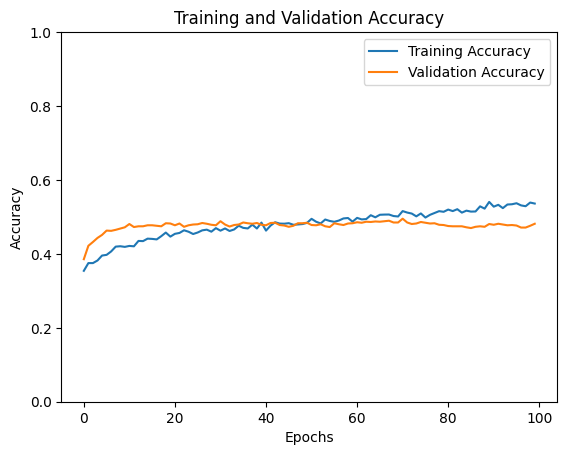

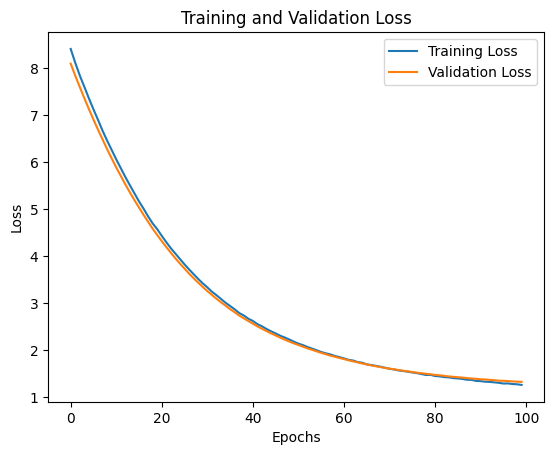

In [116]:

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y.shape[1]),
    y=np.argmax(y, axis=1)
)
class_weights = dict(enumerate(class_weights))

# Define the DNN model
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.01)),  # Add L2 regularization
    BatchNormalization(),  # Batch Normalization
    LeakyReLU(alpha=0.1),  # Leaky ReLU activation
    Dropout(0.5),

    Dense(256, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(128, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


### 6. Results

In [184]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities and true labels into class indices
y_pred_original = np.argmax(y_pred, axis=1)
y_test_original = np.argmax(y_test, axis=1)

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_original))


Test Accuracy: 0.46
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Confusion Matrix:
[[309 139  86]
 [178 144 121]
 [193 262 392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.58      0.51       534
           1       0.26      0.33      0.29       443
           2       0.65      0.46      0.54       847

    accuracy                           0.46      1824
   macro avg       0.46      0.46      0.45      1824
weighted avg       0.50      0.46      0.47      1824



### 7. Final Predictions on Test Set

In [111]:
# Code for Section 7. Final Predictions on Test Set

In [185]:
import numpy as np

# Assuming y_train and y_test are your one-hot encoded target DataFrames
# y_train = df_copy[['FTR_A', 'FTR_D', 'FTR_H']]
# y_test = df_copy[['FTR_A', 'FTR_D', 'FTR_H']]

# Convert one-hot encoded labels to single integer labels
label_mapping = {'FTR_A': 0, 'FTR_D': 1, 'FTR_H': 2}

# Function to convert one-hot to single label
def one_hot_to_single(y):
    return y.idxmax(axis=1).map(label_mapping)

# Apply the function to y_train and y_test
y_train_single = one_hot_to_single(y_train)
y_test_single = one_hot_to_single(y_test)
y_val_single = one_hot_to_single(y_val)

# Verify the conversion
print("Sample of y_train_single:")
print(y_train_single.head())

print("\nSample of y_test_single:")
print(y_test_single.head())


Sample of y_train_single:
3097    2
7956    2
82      1
5050    2
2869    2
dtype: int64

Sample of y_test_single:
8225    2
3133    2
1446    2
4568    1
6022    2
dtype: int64


Model

In [193]:

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBClassifier

# Initialise model
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric=['mlogloss', 'merror'],
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    
    # Lower learning_rate means the model trains more slowly but can generalize better
    learning_rate=0.001,     
    
    # Increased n_estimators to compensate for the lower learning rate
    n_estimators=100,      
    
    # Reduce max_depth to reduce model complexity
    max_depth=4,           
    
    # Increase min_child_weight to require more samples at leaf nodes
    min_child_weight=5,    
    
    # Increase gamma if you want to further penalize splits
    gamma=0.5,             
    
    # Increase regularization to penalize large coefficients
    reg_alpha=2.0,
    reg_lambda=15.0,
    early_stopping=5,
    booster='dart',          # Enable dropout-based boosting
    sample_type='uniform',   # How to sample weights (can be 'uniform' or 'weighted')
    normalize_type='tree',   # How to normalize tree weight (can be 'tree' or 'forest')
    rate_drop=0.1,           # Dropout rate for trees (tune as needed)
    skip_drop=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,   # further reduce the chance of overfitting
    colsample_bynode=0.8,
    grow_policy='lossguide',    # or 'depthwise'
    max_leaves=32,   
)



In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb

# Map your one-hot labels to single integer labels
label_mapping = {'FTR_A': 0, 'FTR_D': 1, 'FTR_H': 2}

def one_hot_to_single(y):
    return y.idxmax(axis=1).map(label_mapping)

y_train_single = one_hot_to_single(y_train)
y_val_single = one_hot_to_single(y_val)
y_test_single = one_hot_to_single(y_test)


# Train the classifier
xgb_clf.fit(
    X_train, 
    y_train_single,
    eval_set=[(X_train, y_train_single), (X_val, y_val_single)],
    verbose=True
)


[0]	validation_0-mlogloss:1.09843	validation_0-merror:0.46179	validation_1-mlogloss:1.09845	validation_1-merror:0.47808
[1]	validation_0-mlogloss:1.09824	validation_0-merror:0.46042	validation_1-mlogloss:1.09829	validation_1-merror:0.46918
[2]	validation_0-mlogloss:1.09806	validation_0-merror:0.46042	validation_1-mlogloss:1.09812	validation_1-merror:0.46164
[3]	validation_0-mlogloss:1.09788	validation_0-merror:0.45751	validation_1-mlogloss:1.09798	validation_1-merror:0.46986
[4]	validation_0-mlogloss:1.09779	validation_0-merror:0.45785	validation_1-mlogloss:1.09789	validation_1-merror:0.46918


/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "early_stopping", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-mlogloss:1.09770	validation_0-merror:0.45836	validation_1-mlogloss:1.09782	validation_1-merror:0.47397
[6]	validation_0-mlogloss:1.09764	validation_0-merror:0.45802	validation_1-mlogloss:1.09776	validation_1-merror:0.46986
[7]	validation_0-mlogloss:1.09746	validation_0-merror:0.45819	validation_1-mlogloss:1.09760	validation_1-merror:0.46849
[8]	validation_0-mlogloss:1.09740	validation_0-merror:0.45819	validation_1-mlogloss:1.09755	validation_1-merror:0.46781
[9]	validation_0-mlogloss:1.09721	validation_0-merror:0.45768	validation_1-mlogloss:1.09739	validation_1-merror:0.46986
[10]	validation_0-mlogloss:1.09712	validation_0-merror:0.45905	validation_1-mlogloss:1.09731	validation_1-merror:0.47055
[11]	validation_0-mlogloss:1.09695	validation_0-merror:0.46042	validation_1-mlogloss:1.09715	validation_1-merror:0.46986
[12]	validation_0-mlogloss:1.09690	validation_0-merror:0.46008	validation_1-mlogloss:1.09711	validation_1-merror:0.46918
[13]	validation_0-mlogloss:1.09686	va

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              device=None, early_stopping=5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=0.5, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=32, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, normalize_type='tree', ...)

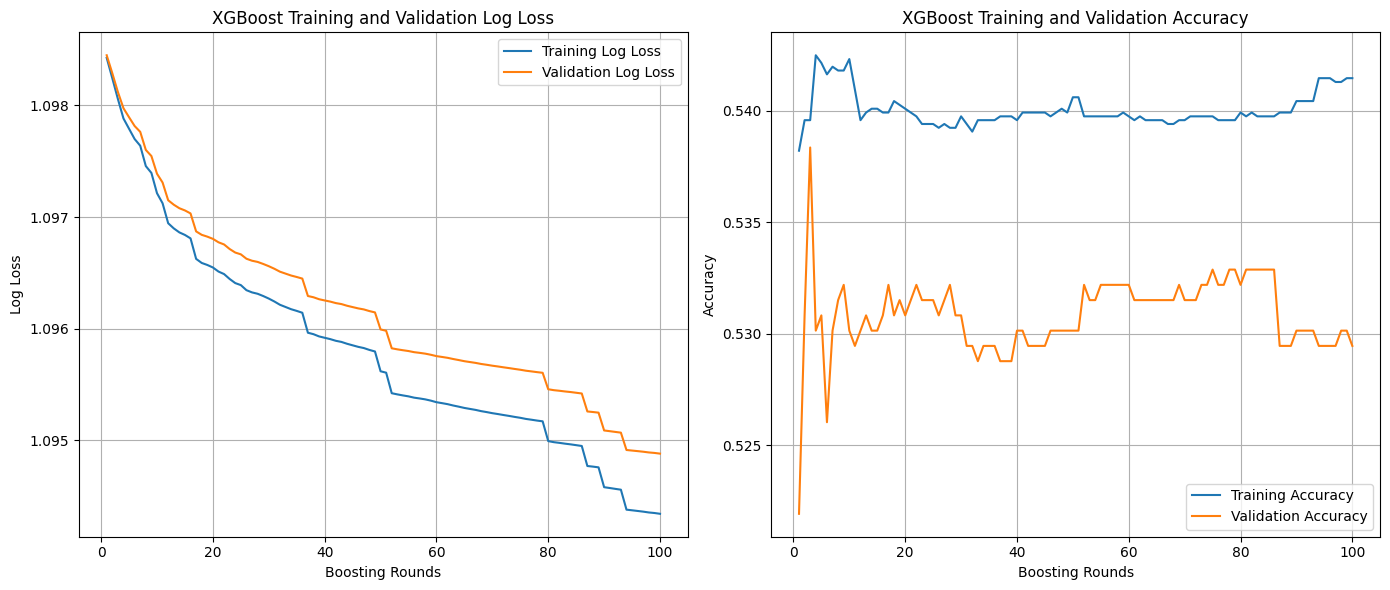

In [195]:
# Retrieve evaluation results
evals_result = xgb_clf.evals_result()

# Extract log loss for training and validation sets
train_logloss = evals_result['validation_0']['mlogloss']
val_logloss = evals_result['validation_1']['mlogloss']

# Extract error rates and convert to accuracy
train_merror = evals_result['validation_0']['merror']
val_merror = evals_result['validation_1']['merror']

train_accuracy = [1 - error for error in train_merror]
val_accuracy = [1 - error for error in val_merror]

# Determine the number of boosting rounds
num_rounds = len(train_logloss)

# Plotting Log Loss and Accuracy
plt.figure(figsize=(14, 6))

# Subplot 1: Log Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_rounds + 1), train_logloss, label='Training Log Loss')
plt.plot(range(1, num_rounds + 1), val_logloss, label='Validation Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_rounds + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_rounds + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

XGBoost Test Accuracy: 0.54

XGBoost Classification Report:
                  precision    recall  f1-score   support

FTR_A (Home Win)       0.54      0.45      0.49       534
    FTR_D (Draw)       0.00      0.00      0.00       443
FTR_H (Away Win)       0.54      0.88      0.67       847

        accuracy                           0.54      1824
       macro avg       0.36      0.44      0.39      1824
    weighted avg       0.41      0.54      0.45      1824


XGBoost Confusion Matrix:
[[241   2 291]
 [101   0 342]
 [103   0 744]]


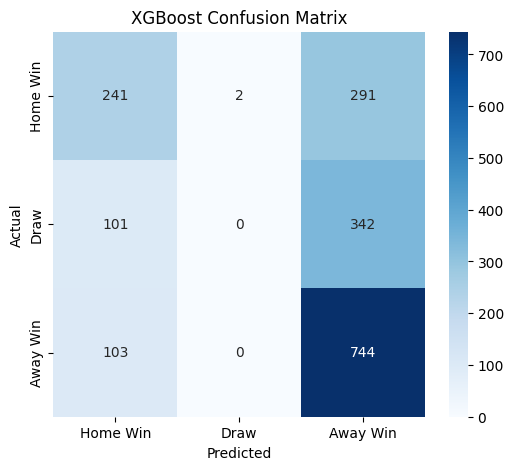

In [196]:
# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate test accuracy
test_accuracy_xgb = accuracy_score(y_test_single, y_pred_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")

# Generate classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test_single, y_pred_xgb, target_names=['FTR_A (Home Win)', 'FTR_D (Draw)', 'FTR_H (Away Win)']))

# Generate confusion matrix
print("\nXGBoost Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_single, y_pred_xgb)
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Home Win', 'Draw', 'Away Win'],
            yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()